# Testing MSE in Consistency Denoising

/home/anton/source/torch-env/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

False
True


  0%|          | 0/40 [00:00<?, ?it/s]

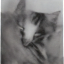

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms 

from diffusers import ConsistencyModelPipeline

device = "cuda"
model_id_or_path = "openai/diffusers-cd_imagenet64_l2"
pipe = ConsistencyModelPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe.to(device)

training_mode = pipe.unet.training
print(training_mode)
if not training_mode:
    pipe.unet.train()
print(pipe.unet.training)

CLASS = [281]

preprocess = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )
image = pipe(num_inference_steps=40, class_labels=CLASS).images[0]
image

In [2]:
pipe.scheduler.sigmas

tensor([8.0000e+01, 6.9451e+01, 6.0117e+01, 5.1880e+01, 4.4630e+01, 3.8266e+01,
        3.2697e+01, 2.7837e+01, 2.3610e+01, 1.9946e+01, 1.6780e+01, 1.4055e+01,
        1.1719e+01, 9.7232e+00, 8.0265e+00, 6.5901e+00, 5.3800e+00, 4.3656e+00,
        3.5197e+00, 2.8184e+00, 2.2404e+00, 1.7672e+00, 1.3824e+00, 1.0717e+00,
        8.2294e-01, 6.2540e-01, 4.6998e-01, 3.4892e-01, 2.5563e-01, 1.8459e-01,
        1.3120e-01, 9.1628e-02, 6.2762e-02, 4.2071e-02, 2.7525e-02, 1.7522e-02,
        1.0812e-02, 6.4371e-03, 3.6766e-03, 2.0000e-03, 2.0000e-03])

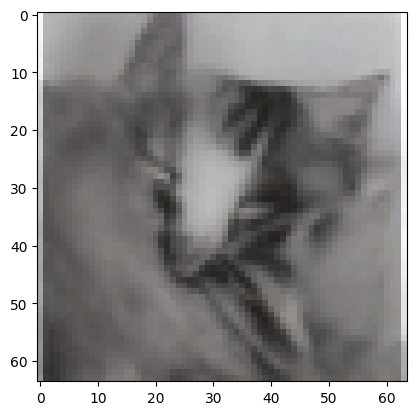

In [3]:
plt.imshow(
    np.moveaxis(np.array(transforms.ToTensor()(image)), 0, -1)
)

## Denoiser

In [11]:
def denoise(sample, sigma):
    
    t = pipe.scheduler.sigma_to_t(sigma)
    c_skip, c_out = pipe.scheduler.get_scalings_for_boundary_condition(sigma)
    scaled_sample = sample / ((sigma**2 + 1) ** 0.5)
    
    model_output = pipe.unet(
        scaled_sample, 
        t, 
        class_labels=torch.tensor(CLASS, device=device),
        return_dict=False
    )[0]

    
    return  c_out * model_output + c_skip * sample

## Add noise

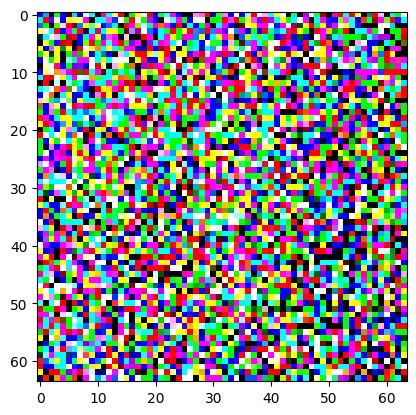

In [20]:
sigma = 5

# img = preprocess(image)[None, :].to(device).type(torch.float16)

img = torch.load("AWESOME_CAT.PT").to("cuda").type(torch.float16)

z = sigma * torch.randn(img.shape).to(device).type(torch.float16)
img_n = (img + z).type(torch.float32)

plt.imshow(pipe.postprocess_image(img_n, "np")[0])

## Denoised

/tmp/ipykernel_3585/3901203834.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_dn = torch.tensor(denoise(img + z, sigma).detach(), dtype=torch.float32)


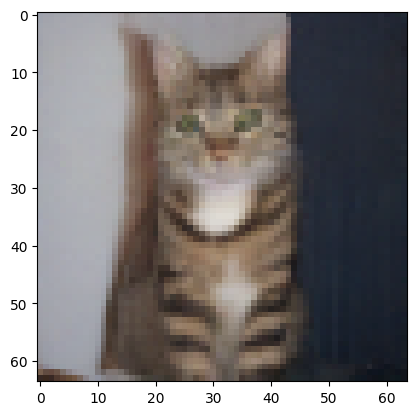

In [21]:
img_dn = torch.tensor(denoise(img + z, sigma).detach(), dtype=torch.float32)

plt.imshow(pipe.postprocess_image(img_dn.cpu(), "np")[0])

In [18]:
# test = torch.load("AWESOME_CAT.PT")
# plt.imshow(pipe.postprocess_image(test.cpu(), "np")[0])

## Denoise image as a vector

/tmp/ipykernel_3585/677880639.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(pipe.postprocess_image(torch.tensor(img_dn, dtype=torch.float32).detach().cpu(), "np")[0])


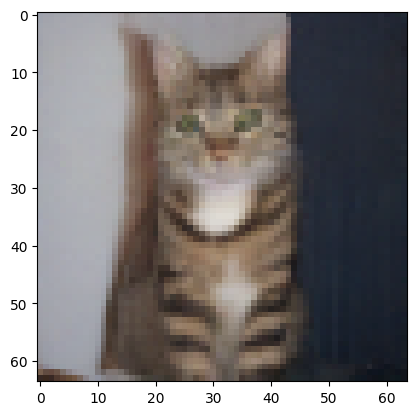

In [22]:
def denoise_v(img_v, sigma):
    sample = torch.reshape(img_v, (1,3,64,64))
    sample_dn = denoise(sample, sigma)
    return torch.reshape(sample_dn, (12288,))

img_n = img + z
img_n_v = torch.reshape(img_n, (12288,))
img_n_v.requires_grad_()

img_dn_v = denoise_v(img_n_v, sigma=5)
img_dn = torch.reshape(img_dn_v, (1,3,64,64))

plt.imshow(pipe.postprocess_image(torch.tensor(img_dn, dtype=torch.float32).detach().cpu(), "np")[0])

/tmp/ipykernel_3585/3039277288.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(pipe.postprocess_image(torch.tensor(img_n, dtype=torch.float32).detach().cpu(), "np")[0])


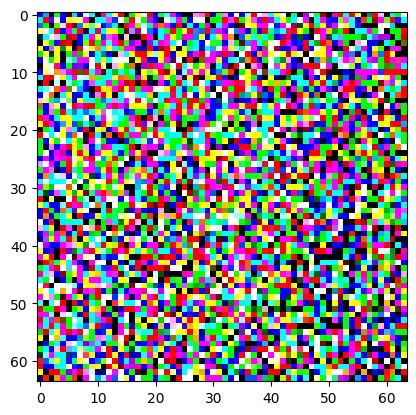

In [23]:
plt.imshow(pipe.postprocess_image(torch.tensor(img_n, dtype=torch.float32).detach().cpu(), "np")[0])

In [24]:
timesteps = list(reversed(range(40)))
pipe.scheduler.set_timesteps(timesteps=timesteps, device=device)
pipe.scheduler.sigmas

tensor([8.0000e+01, 6.9451e+01, 6.0117e+01, 5.1880e+01, 4.4630e+01, 3.8266e+01,
        3.2697e+01, 2.7837e+01, 2.3610e+01, 1.9946e+01, 1.6780e+01, 1.4055e+01,
        1.1719e+01, 9.7232e+00, 8.0265e+00, 6.5901e+00, 5.3800e+00, 4.3656e+00,
        3.5197e+00, 2.8184e+00, 2.2404e+00, 1.7672e+00, 1.3824e+00, 1.0717e+00,
        8.2294e-01, 6.2540e-01, 4.6998e-01, 3.4892e-01, 2.5563e-01, 1.8459e-01,
        1.3120e-01, 9.1628e-02, 6.2762e-02, 4.2071e-02, 2.7525e-02, 1.7522e-02,
        1.0812e-02, 6.4371e-03, 3.6766e-03, 2.0000e-03, 2.0000e-03])

## Take Jacobian at single noise level

In [25]:
from torch.autograd import grad
from functorch.experimental import chunk_vmap

def jacobian_eff(output, input, index=0, device="cuda", chunks=64):
    print(output.shape)
    N = output.numel()
    I_N = torch.eye(N).to(device)

    def get_vjp(v):
        return grad(output, input, v, retain_graph=True)[0]
        
    jacobian = chunk_vmap(get_vjp, chunks=chunks)(I_N)
    return jacobian

In [26]:
# J = jacobian_eff(img_dn_v, img_n_v)

In [ ]:
J_np = J.cpu().numpy()

from sklearn.decomposition import SparsePCA

spca = SparsePCA(n_components=15, alpha=0.0, ridge_alpha=0.0, max_iter=1000, random_state=42)
spca_out = spca.fit_transform(J_np)

In [ ]:
np.linalg.norm(spca_out)

In [ ]:
components = spca_out.transpose()

C = components[0].reshape((3, 64, 64))
C = np.moveaxis(C, 0, -1)
plt.imshow((C + 0.5)/2)

In [27]:
def plot_components(spca_out, shape=(3, 64, 64), cols=5, rows=3, filename=None):
    components = spca_out.transpose()
    n = components.shape[0]
    
    fig, axs = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axs = axs.flatten() if n > 1 else [axs]
    
    for i, comp in enumerate(components):
        if i < n:
            C = comp.reshape(shape)
            C = np.moveaxis(C, 0, -1)
            axs[i].imshow(C/1.5 + 0.5)
            axs[i].set_title(f"#{i+1}")
            axs[i].axis('off')
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=300)
# a = plot_components(spca_out)

## Vary $\sigma$ in experiments



In [ ]:
from sklearn.decomposition import SparsePCA


def run(img_n_v, sigmas):

    spca = SparsePCA(n_components=15, alpha=0.075, ridge_alpha=0.0, max_iter=1000, random_state=42)
    
    for s in sigmas:
        img_dn_v = denoise_v(img_n_v, sigma=s)
        
        J = jacobian_eff(img_dn_v, img_n_v)

        J_np = J.cpu().numpy()

        spca_out = spca.fit_transform(J_np)

        plot_components(spca_out, filename=f"cat_spca_sigma_{s}.jpg")
        
run(img_n_v, sigmas=[4.5, 5, 5.5])

torch.Size([12288])


/home/anton/source/torch-env/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_flash_attention_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
